## Mobile Phone Price EDA

I have worked with this dataset before and even uploaded a video for it on YouTube!

The previous notebook is [here](Cleaning_Mobile_Phone_Price_Dataset_Using_Shell_Scripting.ipynb) and the video is [here](https://youtube.com/watch?v=n2FNnCnCa3Q) for Persian speakers.

In [1]:
# Data analysis
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style='ticks')

In [3]:
df = pd.read_csv('./datasets/mobile_phone_price.csv')

In [4]:
df.sample(10)

,Brand,Model,Storage,RAM,Screen Size (inches),Camera (MP),Battery Capacity (mAh),Price ($)
123,Asus,Zenfone 8 Flip,128GB,8GB,6.67,64MP + 12MP + 12MP,5000,$899
71,Samsung,Galaxy A22 5G,128 GB,4 GB,6.6,48 + 5 + 2,5000,239
60,Oppo,Reno6 Pro 5G,128 GB,12 GB,6.55,64 + 8 + 2 + 2,4500,659
327,Oppo,F19 Pro+ 5G,128,8,6.43,64+8+2+2,4310,419
351,Samsung,Galaxy S21+ 5G,256,8,6.7,12+64+12,4800,999
216,Realme,C11 2021,32GB,2GB,6.52,8MP + 2MP,5000,$99
51,Apple,iPhone 11 Pro Max,256 GB,4 GB,6.5,12 + 12 + 12,3969,1099
240,Nokia,C20 Plus,32GB,3GB,6.5,8MP + 2MP,4950,$99
26,Samsung,Galaxy A03s,32 GB,3 GB,6.5,13 + 2 + 2,5000,139
242,Oppo,Reno 6 Pro 5G,128GB,12GB,6.55,64MP + 8MP + 2MP,4500,$549


### It's time to clean up

Renaming the columns:

In [5]:
df.columns

Index(['Brand', 'Model', 'Storage ', 'RAM ', 'Screen Size (inches)',
       'Camera (MP)', 'Battery Capacity (mAh)', 'Price ($)'],
      dtype='object')

In [6]:
df.rename(columns={
    'Storage ': 'Storage',
    'RAM ': 'RAM',
    'Screen Size (inches)': 'Screen Size',
    'Camera (MP)': 'Camera',
    'Battery Capacity (mAh)': 'Battery Capacity',
    'Price ($)': 'Price',
}, inplace=True)

Removing extra tags from the `Storage`, `RAM`, `Screen Size`, and `Camera` fields:

In [7]:
cols = ['Storage', 'RAM']
for col in cols:
    df[col] = df[col].str.extract(r'^(\d+)')

In [8]:
df[df['Screen Size'].str.contains('[^0-9\.]', regex=True)]

,Brand,Model,Storage,RAM,Screen Size,Camera,Battery Capacity,Price
88,LG,Wing,256,8,6.8 + 3.9,64MP + 13MP + 12MP,4000,$999
373,Samsung,Galaxy Z Fold2 5G,256,12,7.6 (unfolded),12+12+12,4500,1999


We can get the above numbers in different ways, but the case for record 88 (LG Wing) is different; because there is only one item and it caused the column structure to be damaged, we can delete it:

In [9]:
df.drop(88, inplace=True)

In [10]:
df['Screen Size'] = df['Screen Size'].str.extract('(\d+(?:\.\d+)?)')

In [11]:
df['Camera'] = (
    df['Camera']
    .str.extractall(r'(\d+(?:\.\d+)?)')
    .reset_index()
    .pivot(index='level_0', columns='match', values=0)
    .apply(lambda x: x.str.cat(sep='+'), axis=1)
)

And finally, we have to standardize the price format:

In [12]:
df['Price'] = (
    df['Price']
    .str.replace(',', '')
    .str.extract('(\d+)')
)

### Let's go for analysis

This is the cleaned dataset:

In [13]:
df.sample(10)

,Brand,Model,Storage,RAM,Screen Size,Camera,Battery Capacity,Price
204,Vivo,Y72 5G,128,8,6.58,64+8+2,5000,339
337,Motorola,Moto G9 Plus,128,4,6.81,64+8+2+2,5000,279
33,Oppo,A53s,128,6,6.5,13+2+2,5000,259
233,Realme,Narzo 50A,64,4,6.5,50+2,5000,149
54,Samsung,Galaxy A52s 5G,128,6,6.5,64+12+5+5,4500,459
339,Samsung,Galaxy A32 5G,128,4,6.5,48+8+5+2,5000,279
19,Oppo,A94,128,8,6.43,48+8+2+2,4310,379
283,Oppo,A31,128,4,6.5,12+2+2,4230,199
305,Apple,iPhone 13,128,6,6.1,12+12+12,2815,799
271,Oppo,A54,64,4,6.51,13+2+2,5000,199


Some feature engineering:

In [14]:
df['Cameras'] = df['Camera'].str.count(r'\+')

In [15]:
expanded_cameras_data = (
    df['Camera']
    .str.split('+', expand=True)
    .add_prefix('Camera_')
)

In [16]:
expanded_cameras_data.sample(10)

,Camera_0,Camera_1,Camera_2,Camera_3
169,64,8,5,2
235,48,8,2,2
393,48,16,5,2
125,48,8,2,2
42,48,8,2,2
370,48,8,2,2
287,25,8,5,None
1,108,10,10,12
353,64,12,2,2
279,13,8,2,2


In [17]:
expanded_cameras_data.fillna(0, inplace=True)

In [18]:
df.drop(columns=['Camera'], inplace=True)

In [19]:
df = pd.concat([df, expanded_cameras_data], axis=1)

In [20]:
df.sample(10)

,Brand,Model,Storage,RAM,Screen Size,Battery Capacity,Price,Cameras,Camera_0,Camera_1,Camera_2,Camera_3
15,Xiaomi,Mi 11 Lite 5G NE,128,6,6.55,4250,329,2,64,8,5,0
117,Xiaomi,Redmi 10 Prime,128,6,6.5,6000,219,3,50,8,2,2
73,Xiaomi,Mi 11 Lite 5G,128,6,6.55,4250,369,2,64,8,5,0
8,Oppo,Reno6 Pro+ 5G,128,8,6.55,4500,699,3,50,13,16,2
13,Apple,iPhone 12 Mini,64,4,5.4,2227,699,1,12,12,0,0
82,Realme,GT Master Edition,128,8,6.43,4300,399,2,64,8,2,0
133,Samsung,Galaxy A52s 5G,128,6,6.5,4500,449,3,64,12,5,5
305,Apple,iPhone 13,128,6,6.1,2815,799,2,12,12,12,0
229,Xiaomi,Redmi Note 10 Pro Max,128,8,6.67,5020,329,3,108,8,5,2
206,Xiaomi,Mi 10i,128,6,6.67,4820,319,3,108,8,2,2


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406 entries, 0 to 406
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Brand             406 non-null    object
 1   Model             406 non-null    object
 2   Storage           406 non-null    object
 3   RAM               406 non-null    object
 4   Screen Size       406 non-null    object
 5   Battery Capacity  406 non-null    int64 
 6   Price             406 non-null    object
 7   Cameras           406 non-null    int64 
 8   Camera_0          406 non-null    object
 9   Camera_1          406 non-null    object
 10  Camera_2          406 non-null    object
 11  Camera_3          406 non-null    object
dtypes: int64(2), object(10)
memory usage: 41.2+ KB


In [22]:
df = df.astype({
    'Brand': 'category',
    'Storage': 'int16',
    'RAM': 'int16',
    'Screen Size': 'float16',
    'Battery Capacity': 'int16',
    'Price': 'int16',
    'Cameras': 'int8',
    'Camera_0': 'float16',
    'Camera_1': 'float16',
    'Camera_2': 'float16',
    'Camera_3': 'float16',
})

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406 entries, 0 to 406
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Brand             406 non-null    category
 1   Model             406 non-null    object  
 2   Storage           406 non-null    int16   
 3   RAM               406 non-null    int16   
 4   Screen Size       406 non-null    float16 
 5   Battery Capacity  406 non-null    int16   
 6   Price             406 non-null    int16   
 7   Cameras           406 non-null    int8    
 8   Camera_0          406 non-null    float16 
 9   Camera_1          406 non-null    float16 
 10  Camera_2          406 non-null    float16 
 11  Camera_3          406 non-null    float16 
dtypes: category(1), float16(5), int16(4), int8(1), object(1)
memory usage: 14.9+ KB


#### What is the average price of all phones?

In [24]:
df['Price'].mean()

406.85960591133005

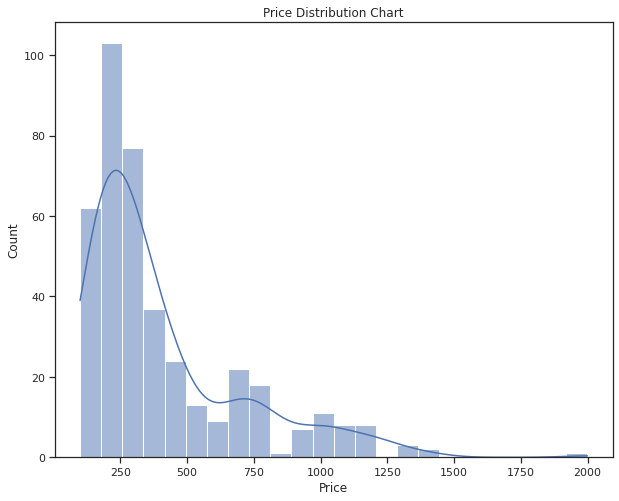

In [25]:
plt.figure(figsize=(10, 8))
sns.histplot(data=df['Price'], kde=True)
plt.title('Price Distribution Chart')
plt.show()

#### What is the average price of phones by brand?

In [26]:
brands_average_price_data = df.groupby('Brand')['Price'].mean()

In [27]:
brands_average_price_data

Brand
Apple          745.666667
Asus           874.000000
Blackberry     499.000000
CAT            299.000000
Google         699.000000
Huawei         783.166667
LG             424.000000
Motorola       278.130435
Nokia          244.714286
OnePlus        644.333333
Oppo           376.142857
Realme         206.906977
Samsung        480.405063
Sony          1299.000000
Vivo           323.000000
Xiaomi         282.880597
Name: Price, dtype: float64

In [28]:
brands_average_price_data.reset_index()

,Brand,Price
0,Apple,745.666667
1,Asus,874.000000
2,Blackberry,499.000000
3,CAT,299.000000
4,Google,699.000000
5,Huawei,783.166667
6,LG,424.000000
7,Motorola,278.130435
8,Nokia,244.714286
9,OnePlus,644.333333


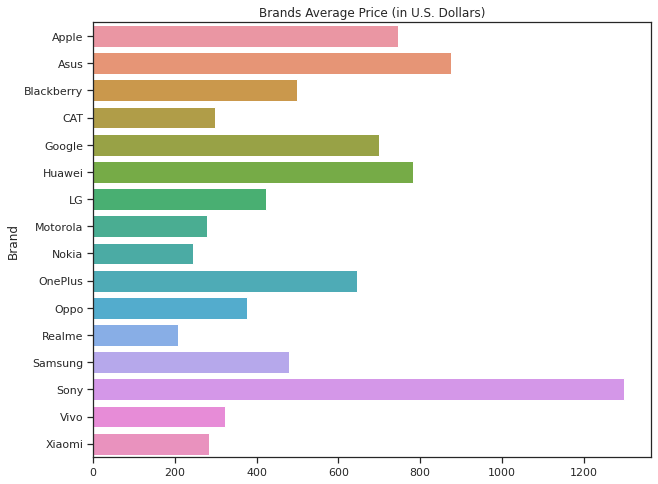

In [29]:
plt.figure(figsize=(10, 8))
# sns.barplot(data=brands_average_price_data.reset_index(), x='Price', y='Brand')
sns.barplot(x=brands_average_price_data.values, y=brands_average_price_data.index)
plt.title('Brands Average Price (in U.S. Dollars)')
plt.show()

#### What is the average battery capacity of phones by brand?

In [30]:
brands_average_battery_capacity_data = df.groupby('Brand')['Battery Capacity'].mean()

In [31]:
brands_average_battery_capacity_data

Brand
Apple         2863.900000
Asus          5000.000000
Blackberry    3500.000000
CAT           4200.000000
Google        4019.857143
Huawei        4161.666667
LG            4150.000000
Motorola      5021.739130
Nokia         4502.857143
OnePlus       4415.000000
Oppo          4631.339286
Realme        5176.744186
Samsung       4936.708861
Sony          4500.000000
Vivo          4750.000000
Xiaomi        5101.791045
Name: Battery Capacity, dtype: float64

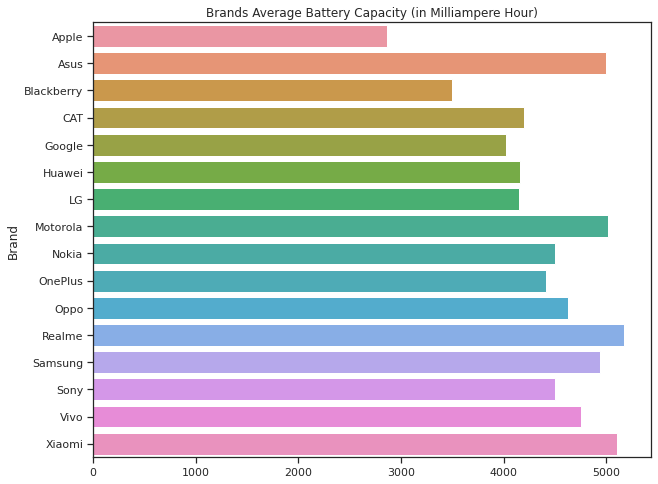

In [32]:
plt.figure(figsize=(10, 8))
# sns.barplot(data=brands_average_battery_capacity_data.reset_index(), x='Battery Capacity', y='Brand')
sns.barplot(x=brands_average_battery_capacity_data.values, y=brands_average_battery_capacity_data.index)
plt.title('Brands Average Battery Capacity (in Milliampere Hour)')
plt.show()

#### What is the average RAM of phones by brand?

In [33]:
brands_average_ram_data = df.groupby('Brand')['RAM'].mean()

In [34]:
brands_average_ram_data

Brand
Apple         3.966667
Asus          7.500000
Blackberry    5.333333
CAT           3.000000
Google        7.428571
Huawei        7.333333
LG            6.000000
Motorola      4.521739
Nokia         4.000000
OnePlus       8.666667
Oppo          6.928571
Realme        4.976744
Samsung       6.025316
Sony          8.000000
Vivo          6.828571
Xiaomi        5.626866
Name: RAM, dtype: float64

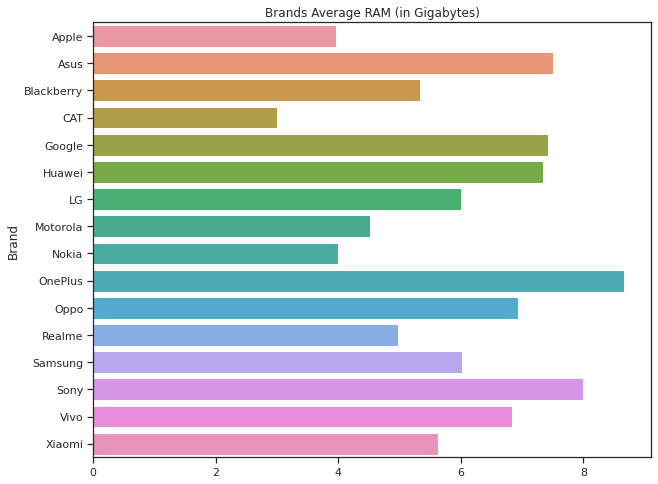

In [35]:
plt.figure(figsize=(10, 8))
# sns.barplot(data=brands_average_ram_data.reset_index(), x='RAM', y='Brand')
sns.barplot(x=brands_average_ram_data.values, y=brands_average_ram_data.index)
plt.title('Brands Average RAM (in Gigabytes)')
plt.show()

#### What is the average storage of phones by brand?

In [36]:
brands_average_storage_data = df.groupby('Brand')['Storage'].mean()

In [37]:
brands_average_storage_data

Brand
Apple         128.000000
Asus          160.000000
Blackberry     64.000000
CAT            32.000000
Google        128.000000
Huawei        218.666667
LG            128.000000
Motorola      105.739130
Nokia          74.285714
OnePlus       170.666667
Oppo          130.857143
Realme         96.744186
Samsung       130.835443
Sony          128.000000
Vivo          119.771429
Xiaomi        121.313433
Name: Storage, dtype: float64

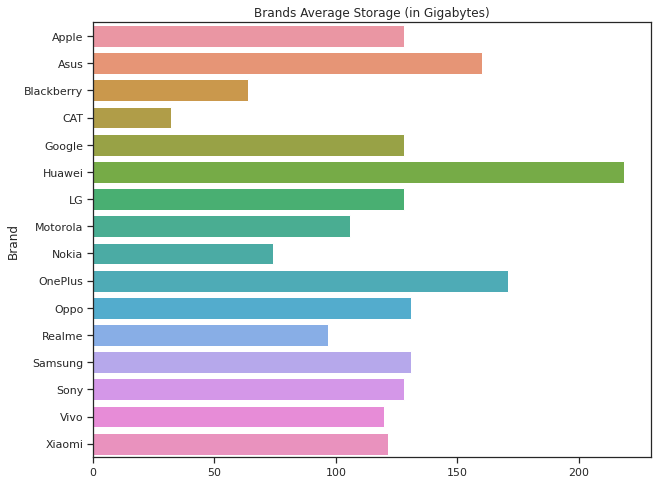

In [38]:
plt.figure(figsize=(10, 8))
# sns.barplot(data=brands_average_storage_data.reset_index(), x='Storage', y='Brand')
sns.barplot(x=brands_average_storage_data.values, y=brands_average_storage_data.index)
plt.title('Brands Average Storage (in Gigabytes)')
plt.show()

#### What is the average screen size of phones by brand?

In [39]:
brands_average_screen_size_data = df.groupby('Brand')['Screen Size'].mean()

In [40]:
brands_average_screen_size_data

Brand
Apple         5.870443
Asus          6.505859
Blackberry    4.996094
CAT           5.500000
Google        6.099330
Huawei        6.522461
LG            6.750000
Motorola      6.591712
Nokia         6.533622
OnePlus       6.564063
Oppo          6.494141
Realme        6.510356
Samsung       6.557852
Sony          6.101562
Vivo          6.530692
Xiaomi        6.576259
Name: Screen Size, dtype: float32

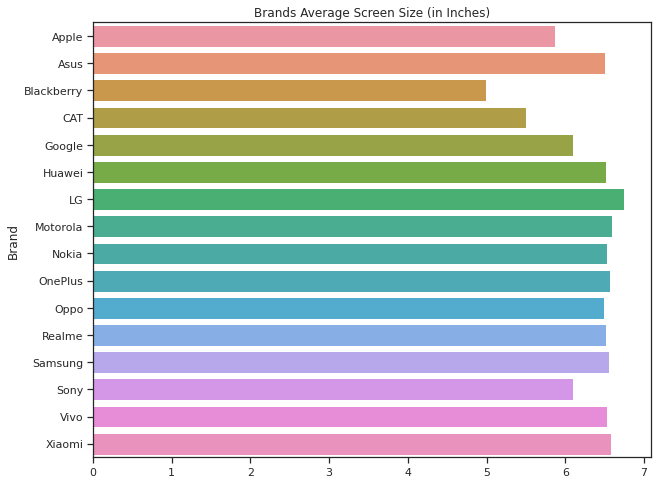

In [41]:
plt.figure(figsize=(10, 8))
# sns.barplot(data=brands_average_screen_size_data.reset_index(), x='Screen Size', y='Brand')
sns.barplot(x=brands_average_screen_size_data.values, y=brands_average_screen_size_data.index)
plt.title('Brands Average Screen Size (in Inches)')
plt.show()

#### What is the correlation between price and storage?

In [42]:
df['Price'].corr(df['Storage'])

0.7081483627880374

#### What is the correlation between price and RAM?

In [43]:
df['Price'].corr(df['RAM'])

0.6365242498103476

#### What is the correlation between price and screen size?

In [44]:
df['Price'].corr(df['Screen Size'])

0.041356568766993194

#### What is the abundance of brands?

In [45]:
brands_frequency_data = df['Brand'].value_counts()

In [46]:
brands_frequency_data

Samsung       79
Xiaomi        67
Oppo          56
Realme        43
Vivo          35
Apple         30
Nokia         28
Motorola      23
OnePlus       15
Huawei        12
Google         7
Asus           4
Blackberry     3
LG             2
CAT            1
Sony           1
Name: Brand, dtype: int64

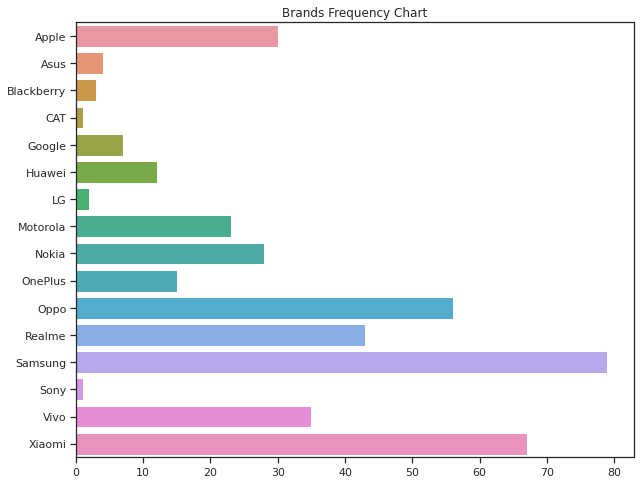

In [47]:
plt.figure(figsize=(10, 8))
# sns.barplot(data=brands_frequency_data.reset_index(), x='Brand', y='index')
sns.barplot(x=brands_frequency_data.values, y=brands_frequency_data.index)
plt.title('Brands Frequency Chart')
plt.show()